In [313]:
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
from itertools import combinations, product
import scipy.stats as stats

In [314]:
# need affected/unaffected information
# these files can be found on sherlock
# '../data/v34.vcf.ped' = /scratch/PI/dpwall/DATA/iHART/vcf/v3.4/v34.vcf.ped
# '../data/ssc.ped' = /scratch/PI/dpwall/DATA/iHART/vcf/SSC/ssc.ped

ped_files = ['../data/v34.vcf.ped', '../data/ssc.ped', '../data/spark.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [382]:
#chroms = [str(x) for x in range(1, 23)] #+ 
chroms = ['X']

ihart_family_sizes = [3, 4, 5, 6]
ihart_phase_dir = '../phased_ihart'

ihart_chip_family_sizes = [3, 4, 5, 6]
ihart_chip_phase_dir = '../phased_ihart_chip'

ssc_family_sizes = [3, 4]
ssc_phase_dir = '../phased_ssc'

spark_family_sizes = [4, 5, 6, 7]
spark_phase_dir = '../phased_spark'


In [383]:
def load_crossovers(phase_dir, family_sizes):
    sibpair_to_mat_crossovers = defaultdict(lambda: [[] for _ in chroms])
    sibpair_to_pat_crossovers = defaultdict(lambda: [[] for _ in chroms])
    
    for i, chrom in enumerate(chroms):
        print(chrom, end=' ')

        # pull families
        family_to_individuals = dict()
        for j in family_sizes:
            with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f: 
                next(f) # skip header
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    family_to_individuals[family_key] = pieces[1:(1+j)]


        # now read recombination info
        for j in family_sizes:
            with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
                next(f) # skip header

                prev_famkey, prev_inh_state, prev_positions = None, None, None
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    inheritance_state = [int(x) for x in pieces[1:(2+(j*2))]]
                    start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                    length = end_pos - start_pos + 1
                    inds = family_to_individuals[family_key]
                    
                    if inheritance_state[-1] == 0:
                        if prev_famkey == family_key:
                            for k, (old_s, new_s, old_pos) in enumerate(zip(prev_inh_state, inheritance_state[4:-1], prev_positions)):
                                if new_s != -1:
                                    if (old_s is not None) and (old_s != new_s):
                                        # a crossover happened
                                        if k%2 == 0:
                                            child = inds[2+int(k/2)]
                                            ind = inds[2]
                                            current = sibpair_to_mat_crossovers[(min(child, ind), max(child, ind))][i]
                                            if (len(current) == 0 or current[-1][1] < old_pos):# and (start_pos-old_pos < 10):
                                                sibpair_to_mat_crossovers[(min(child, ind), max(child, ind))][i].append((old_pos, start_pos))
                                        else:
                                            child = inds[2+int((k-1)/2)]
                                            ind = inds[2]
                                            current = sibpair_to_pat_crossovers[(min(child, ind), max(child, ind))][i]
                                            if (len(current) == 0 or current[-1][1] < old_pos):# and (start_pos-old_pos < 10):
                                                sibpair_to_pat_crossovers[(min(child, ind), max(child, ind))][i].append((old_pos, start_pos))
                                    prev_inh_state[k] = new_s
                                    prev_positions[k] = end_pos
                        else:
                            prev_famkey = family_key
                            prev_inh_state = [None if x == -1 else x for x in inheritance_state[4:-1]]
                            prev_positions = [end_pos for _ in prev_inh_state]
                            
                    
    return sibpair_to_mat_crossovers, sibpair_to_pat_crossovers

print('iHART')
ihart_sibpair_to_mat_crossovers, ihart_sibpair_to_pat_crossovers = load_crossovers(ihart_phase_dir, ihart_family_sizes)
print('iHART chip')
ihart_chip_sibpair_to_mat_crossovers, ihart_chip_sibpair_to_pat_crossovers = load_crossovers(ihart_chip_phase_dir, ihart_chip_family_sizes)
print('SSC')
ssc_sibpair_to_mat_crossovers, ssc_sibpair_to_pat_crossovers = load_crossovers(ssc_phase_dir, ssc_family_sizes)
print('Spark')
spark_sibpair_to_mat_crossovers, spark_sibpair_to_pat_crossovers = load_crossovers(spark_phase_dir, spark_family_sizes)


iHART
X iHART chip
X SSC
X Spark
X 

In [384]:
ihart_sibpairs = sorted(set(ihart_sibpair_to_mat_crossovers.keys()) | set(ihart_sibpair_to_pat_crossovers.keys()))
print(len(ihart_sibpairs))

ihart_chip_sibpairs = sorted(set(ihart_chip_sibpair_to_mat_crossovers.keys()) | set(ihart_chip_sibpair_to_pat_crossovers.keys()))
print(len(ihart_chip_sibpairs))

ssc_sibpairs = sorted(set(ssc_sibpair_to_mat_crossovers.keys()) | set(ssc_sibpair_to_pat_crossovers.keys()))
print(len(ssc_sibpairs))

spark_sibpairs = sorted(set(spark_sibpair_to_mat_crossovers.keys()) | set(spark_sibpair_to_pat_crossovers.keys()))
print(len(spark_sibpairs))



1303
425
517
1075


In [385]:
def remove_gene_transversions(sibpair_to_crossovers):
    num_removed = 0
    for sibpair, crossovers in sibpair_to_crossovers.items():
        for i, chrom in enumerate(chroms):
            chrom_cross = np.array(crossovers[i])
            while chrom_cross.shape[0] > 1 and np.min(chrom_cross[1:, 0] - chrom_cross[:-1, 1]) < 1000000: 
                j = np.argmin(chrom_cross[1:, 0] - chrom_cross[:-1, 1])
                del crossovers[i][j]
                del crossovers[i][j]
                num_removed += 2
                chrom_cross = np.array(crossovers[i])
    print(num_removed)
    
#remove_gene_transversions(ihart_sibpair_to_mat_crossovers)
#remove_gene_transversions(ihart_sibpair_to_pat_crossovers)
#
#remove_gene_transversions(ssc_sibpair_to_mat_crossovers)
#remove_gene_transversions(ssc_sibpair_to_pat_crossovers)
#
#remove_gene_transversions(spark_sibpair_to_mat_crossovers)
#remove_gene_transversions(spark_sibpair_to_pat_crossovers)



ValueError: zero-size array to reduction operation maximum which has no identity

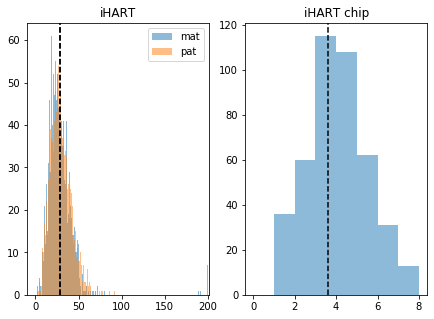

In [386]:
plt.figure(figsize=(15, 5))

clip = 200

plt.subplot(1, 4, 1)
plt.title('iHART')
num_cross = np.clip([len(v[0]) for k, v in ihart_sibpair_to_mat_crossovers.items()], None, clip)
plt.hist(num_cross, bins=np.arange(0, np.max(num_cross)+1), alpha=0.5, label='mat')
plt.axvline(np.mean(num_cross), color='black', linestyle='--')

num_cross = np.clip([len(v[0]) for k, v in ihart_sibpair_to_pat_crossovers.items()], None, clip)
plt.hist(num_cross, bins=np.arange(0, np.max(num_cross)+1), alpha=0.5, label='pat')
plt.axvline(np.mean(num_cross), color='black', linestyle='--')
plt.xlim([None, clip+1])
plt.legend()

plt.subplot(1, 4, 2)
plt.title('iHART chip')
num_cross = np.clip([len(v[0]) for k, v in ihart_chip_sibpair_to_mat_crossovers.items()], None, clip)
plt.hist(num_cross, bins=np.arange(0, np.max(num_cross)+1), alpha=0.5, label='mat')
plt.axvline(np.mean(num_cross), color='black', linestyle='--')

num_cross = np.clip([len(v[0]) for k, v in ihart_chip_sibpair_to_pat_crossovers.items()], None, clip)
plt.hist(num_cross, bins=np.arange(0, np.max(num_cross)+1), alpha=0.5, label='pat')
plt.axvline(np.mean(num_cross), color='black', linestyle='--')
plt.xlim([None, clip+1])
plt.legend()

plt.subplot(1, 4, 3)
plt.title('SSC')
num_cross = np.clip([len(v[0]) for k, v in ssc_sibpair_to_mat_crossovers.items()], None, clip)
plt.hist(num_cross, bins=np.arange(0, np.max(num_cross)+1), alpha=0.5, label='mat')
plt.axvline(np.mean(num_cross), color='black', linestyle='--')

num_cross = np.clip([len(v[0]) for k, v in ssc_sibpair_to_pat_crossovers.items()], None, clip)
plt.hist(num_cross, bins=np.arange(0, np.max(num_cross)+1), alpha=0.5, label='pat')
plt.axvline(np.mean(num_cross), color='black', linestyle='--')
plt.xlim([None, clip+1])
plt.legend()

plt.subplot(1, 4, 4)
plt.title('SPARK')
num_cross = np.clip([len(v[0]) for k, v in spark_sibpair_to_mat_crossovers.items()], None, clip)
plt.hist(num_cross, bins=np.arange(0, np.max(num_cross)+1), alpha=0.5, label='mat')
plt.axvline(np.mean(num_cross), color='black', linestyle='--')

num_cross = np.clip([len(v[0]) for k, v in spark_sibpair_to_pat_crossovers.items()], None, clip)
plt.hist(num_cross, bins=np.arange(0, np.max(num_cross)+1), alpha=0.5, label='pat')
plt.axvline(np.mean(num_cross), color='black', linestyle='--')
plt.xlim([None, clip+1])
plt.legend()

plt.tight_layout()
plt.show()

ValueError: zero-size array to reduction operation maximum which has no identity

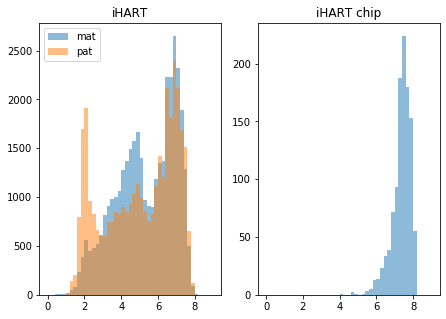

In [387]:
plt.figure(figsize=(15, 5))


plt.subplot(1, 4, 1)
plt.title('iHART')
mat_sep, pat_sep = [], []
for sibpair, crossovers in ihart_sibpair_to_mat_crossovers.items():
    crossovers = crossovers[0]
    for i in range(len(crossovers)-1):
        mat_sep.append(np.mean(crossovers[i+1])-np.mean(crossovers[i]))
for sibpair, crossovers in ihart_sibpair_to_pat_crossovers.items():
    crossovers = crossovers[0]
    for i in range(len(crossovers)-1):
        pat_sep.append(np.mean(crossovers[i+1])-np.mean(crossovers[i]))
plt.hist(np.log10(mat_sep), bins=np.arange(0, np.max(np.log10(mat_sep))+1, 0.2), alpha=0.5, label='mat')
plt.hist(np.log10(pat_sep), bins=np.arange(0, np.max(np.log10(pat_sep))+1, 0.2), alpha=0.5, label='pat')
plt.legend()

plt.subplot(1, 4, 2)
plt.title('iHART chip')
mat_sep, pat_sep = [], []
for sibpair, crossovers in ihart_chip_sibpair_to_mat_crossovers.items():
    crossovers = crossovers[0]
    for i in range(len(crossovers)-1):
        mat_sep.append(np.mean(crossovers[i+1])-np.mean(crossovers[i]))
for sibpair, crossovers in ihart_chip_sibpair_to_pat_crossovers.items():
    crossovers = crossovers[0]
    for i in range(len(crossovers)-1):
        pat_sep.append(np.mean(crossovers[i+1])-np.mean(crossovers[i]))
plt.hist(np.log10(mat_sep), bins=np.arange(0, np.max(np.log10(mat_sep))+1, 0.2), alpha=0.5, label='mat')
plt.hist(np.log10(pat_sep), bins=np.arange(0, np.max(np.log10(pat_sep))+1, 0.2), alpha=0.5, label='pat')
plt.legend()

plt.subplot(1, 4, 3)
plt.title('SSC')
mat_sep, pat_sep = [], []
for sibpair, crossovers in ssc_sibpair_to_mat_crossovers.items():
    crossovers = crossovers[0]
    for i in range(len(crossovers)-1):
        mat_sep.append(np.mean(crossovers[i+1])-np.mean(crossovers[i]))
for sibpair, crossovers in ssc_sibpair_to_pat_crossovers.items():
    crossovers = crossovers[0]
    for i in range(len(crossovers)-1):
        pat_sep.append(np.mean(crossovers[i+1])-np.mean(crossovers[i]))
plt.hist(np.log10(mat_sep), bins=np.arange(0, np.max(np.log10(mat_sep))+1, 0.2), alpha=0.5, label='mat')
plt.hist(np.log10(pat_sep), bins=np.arange(0, np.max(np.log10(pat_sep))+1, 0.2), alpha=0.5, label='pat')
plt.legend()

plt.subplot(1, 4, 4)
plt.title('SPARK')
mat_sep, pat_sep = [], []
for sibpair, crossovers in spark_sibpair_to_mat_crossovers.items():
    crossovers = crossovers[0]
    for i in range(len(crossovers)-1):
        mat_sep.append(np.mean(crossovers[i+1])-np.mean(crossovers[i]))
for sibpair, crossovers in spark_sibpair_to_pat_crossovers.items():
    crossovers = crossovers[0]
    for i in range(len(crossovers)-1):
        pat_sep.append(np.mean(crossovers[i+1])-np.mean(crossovers[i]))
plt.hist(np.log10(mat_sep), bins=np.arange(0, np.max(np.log10(mat_sep))+1, 0.2), alpha=0.5, label='mat')
plt.hist(np.log10(pat_sep), bins=np.arange(0, np.max(np.log10(pat_sep))+1, 0.2), alpha=0.5, label='pat')
plt.legend()

plt.tight_layout()
plt.show()

In [388]:
# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
	'Y': 59373566
}
chrom_length = chrom_lengths[chroms[0]]

binsize = 1000
positions = np.arange(0, chrom_length, binsize)

In [389]:

mat_ihart, pat_ihart = np.zeros(positions.shape), np.zeros(positions.shape)
for sibpair, crossovers in ihart_sibpair_to_mat_crossovers.items():
    crossovers = crossovers[0]
    for s, e in crossovers:
        s_index, e_index = int(np.floor(s/binsize)), int(np.floor(e/binsize))
        mat_ihart[s_index:(e_index+1)] += 1/(e_index-s_index+1)
for sibpair, crossovers in ihart_sibpair_to_pat_crossovers.items():
    crossovers = crossovers[0]
    for s, e in crossovers:
        s_index, e_index = int(np.floor(s/binsize)), int(np.floor(e/binsize))
        pat_ihart[s_index:(e_index+1)] += 1/(e_index-s_index+1)

mat_ihart_chip, pat_ihart_chip = np.zeros(positions.shape), np.zeros(positions.shape)
for sibpair, crossovers in ihart_chip_sibpair_to_mat_crossovers.items():
    crossovers = crossovers[0]
    for s, e in crossovers:
        s_index, e_index = int(np.floor(s/binsize)), int(np.floor(e/binsize))
        mat_ihart_chip[s_index:(e_index+1)] += 1/(e_index-s_index+1)
for sibpair, crossovers in ihart_chip_sibpair_to_pat_crossovers.items():
    crossovers = crossovers[0]
    for s, e in crossovers:
        s_index, e_index = int(np.floor(s/binsize)), int(np.floor(e/binsize))
        pat_ihart_chip[s_index:(e_index+1)] += 1/(e_index-s_index+1)
        
mat_ssc, pat_ssc = np.zeros(positions.shape), np.zeros(positions.shape)
for sibpair, crossovers in ssc_sibpair_to_mat_crossovers.items():
    crossovers = crossovers[0]
    for s, e in crossovers:
        s_index, e_index = int(np.floor(s/binsize)), int(np.floor(e/binsize))
        mat_ssc[s_index:(e_index+1)] += 1/(e_index-s_index+1)
for sibpair, crossovers in ssc_sibpair_to_pat_crossovers.items():
    crossovers = crossovers[0]
    for s, e in crossovers:
        s_index, e_index = int(np.floor(s/binsize)), int(np.floor(e/binsize))
        pat_ssc[s_index:(e_index+1)] += 1/(e_index-s_index+1)

mat_spark, pat_spark = np.zeros(positions.shape), np.zeros(positions.shape)
for sibpair, crossovers in spark_sibpair_to_mat_crossovers.items():
    crossovers = crossovers[0]
    for s, e in crossovers:
        s_index, e_index = int(np.floor(s/binsize)), int(np.floor(e/binsize))
        mat_spark[s_index:(e_index+1)] += 1/(e_index-s_index+1)
for sibpair, crossovers in spark_sibpair_to_pat_crossovers.items():
    crossovers = crossovers[0]
    for s, e in crossovers:
        s_index, e_index = int(np.floor(s/binsize)), int(np.floor(e/binsize))
        pat_spark[s_index:(e_index+1)] += 1/(e_index-s_index+1)
       

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__

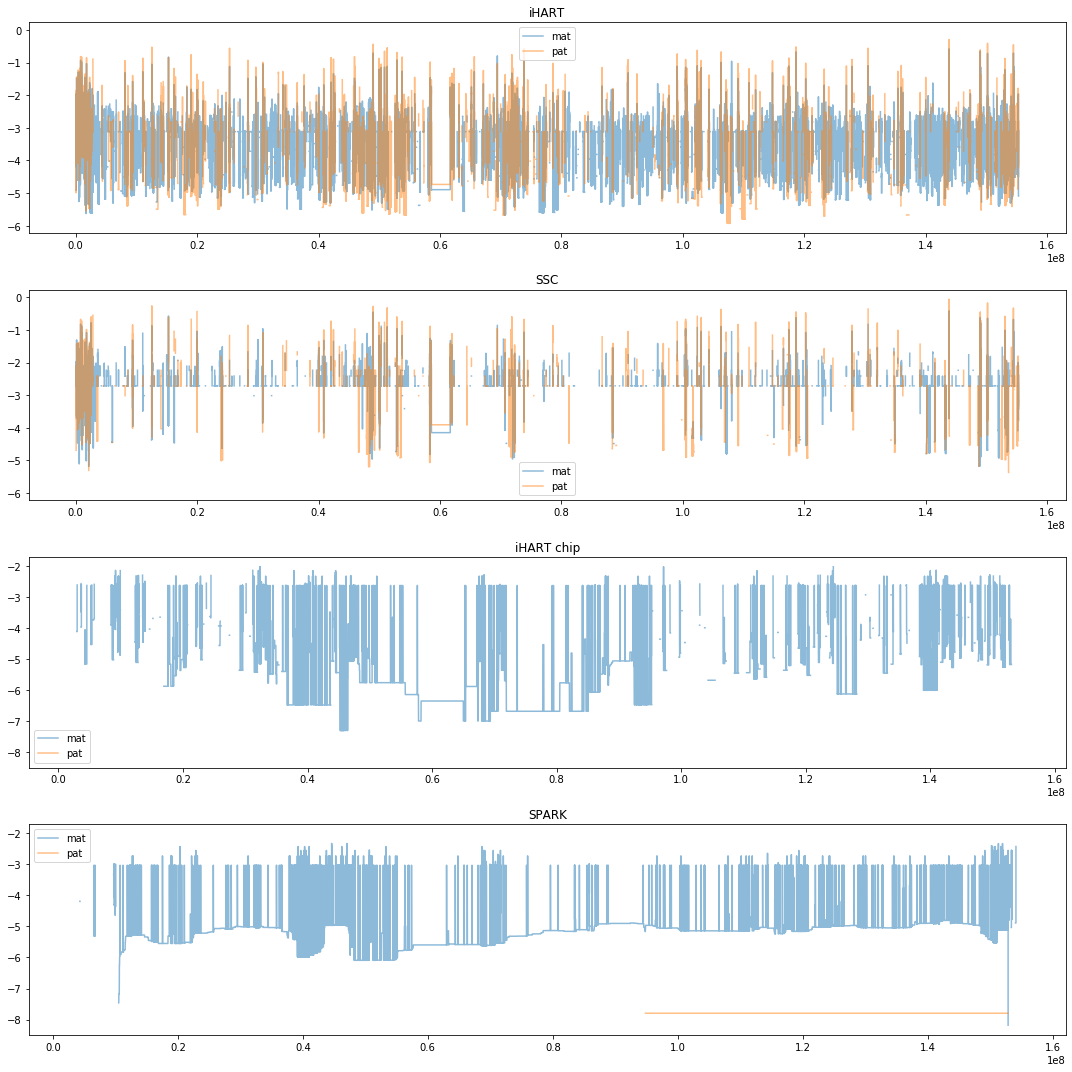

In [390]:
plt.figure(figsize=(15, 15))

indices = positions >= 0

ax = plt.subplot(4, 1, 1)
plt.plot(positions[indices], np.log10(mat_ihart[indices]/len(ihart_sibpairs)), alpha=0.5, label='mat')
plt.plot(positions[indices], np.log10(pat_ihart[indices]/len(ihart_sibpairs)), alpha=0.5, label='pat')
plt.title('iHART')
plt.legend()

plt.subplot(4, 1, 2, sharey=ax)
plt.plot(positions[indices], np.log10(mat_ssc[indices]/len(ssc_sibpairs)), alpha=0.5, label='mat')
plt.plot(positions[indices], np.log10(pat_ssc[indices]/len(ssc_sibpairs)), alpha=0.5, label='pat')
plt.title('SSC')
plt.legend()

ax = plt.subplot(4, 1, 3)
plt.plot(positions[indices], np.log10(mat_ihart_chip[indices]/len(ihart_chip_sibpairs)), alpha=0.5, label='mat')
plt.plot(positions[indices], np.log10(pat_ihart_chip[indices]/len(ihart_chip_sibpairs)), alpha=0.5, label='pat')
plt.title('iHART chip')
plt.legend()

plt.subplot(4, 1, 4, sharey=ax)
plt.plot(positions[indices], np.log10(mat_spark[indices]/len(spark_sibpairs)), alpha=0.5, label='mat')
plt.plot(positions[indices], np.log10(pat_spark[indices]/len(spark_sibpairs)), alpha=0.5, label='pat')
plt.title('SPARK')
plt.legend()

plt.tight_layout()
plt.show()

In [391]:
mat_ihart_status, pat_ihart_status = np.zeros((positions.shape[0], 3)), np.zeros((positions.shape[0], 3))
for sibpair, crossovers in ihart_sibpair_to_mat_crossovers.items():
    if child_id_to_affected[sibpair[0]] == '2' and child_id_to_affected[sibpair[1]] == '2':
        status = 0
    elif (child_id_to_affected[sibpair[0]] == '1' and child_id_to_affected[sibpair[1]] == '2') or (child_id_to_affected[sibpair[0]] == '2' and child_id_to_affected[sibpair[1]] == '1'):
        status = 1
    elif child_id_to_affected[sibpair[0]] == '1' and child_id_to_affected[sibpair[1]] == '1':
        status = 2
    else:
        status = None
        
    if status is not None:
        crossovers = crossovers[0]
        for s, e in crossovers:
            s_index, e_index = int(np.floor(s/binsize)), int(np.floor(e/binsize))
            mat_ihart_status[s_index:(e_index+1), status] += 1/(e_index-s_index+1)
            
for sibpair, crossovers in ihart_sibpair_to_pat_crossovers.items():
    if child_id_to_affected[sibpair[0]] == '2' and child_id_to_affected[sibpair[1]] == '2':
        status = 0
    elif (child_id_to_affected[sibpair[0]] == '1' and child_id_to_affected[sibpair[1]] == '2') or (child_id_to_affected[sibpair[0]] == '2' and child_id_to_affected[sibpair[1]] == '1'):
        status = 1
    elif child_id_to_affected[sibpair[0]] == '1' and child_id_to_affected[sibpair[1]] == '1':
        status = 2
    else:
        status = None
        
    if status is not None:
        crossovers = crossovers[0]
        for s, e in crossovers:
            s_index, e_index = int(np.floor(s/binsize)), int(np.floor(e/binsize))
            pat_ihart_status[s_index:(e_index+1), status] += 1/(e_index-s_index+1)


In [392]:
num_aff_aff_pairs = len([x for x in ihart_sibpairs if child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '2'])
num_aff_typ_pairs = len([x for x in ihart_sibpairs if (child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')])
num_typ_typ_pairs = len([x for x in ihart_sibpairs if child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '1'])

print(num_aff_aff_pairs, num_aff_typ_pairs, num_typ_typ_pairs)


813 479 11


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


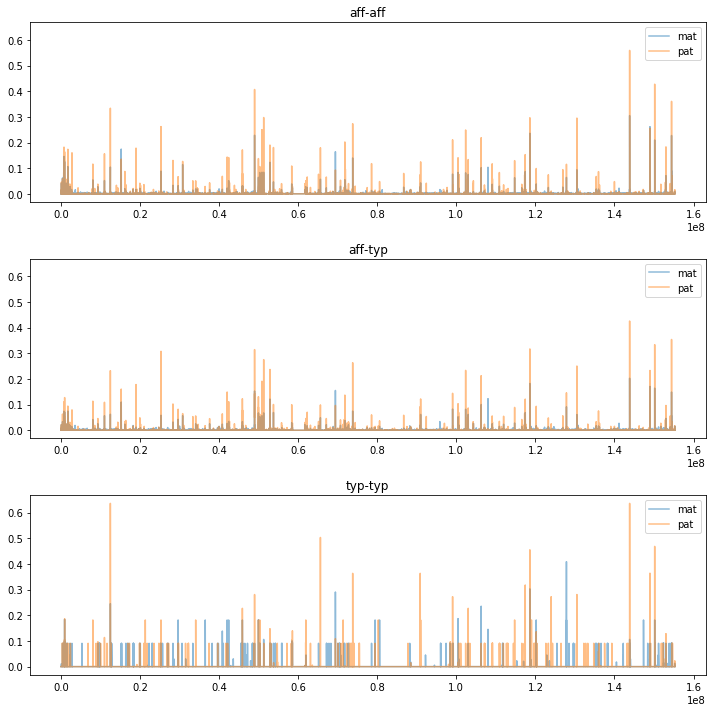

In [393]:
plt.figure(figsize=(10, 10))

indices = positions >= 0

ax = plt.subplot(3, 1, 1)
plt.plot(positions[indices], mat_ihart_status[indices, 0]/num_aff_aff_pairs, alpha=0.5, label='mat')
plt.plot(positions[indices], pat_ihart_status[indices, 0]/num_aff_aff_pairs, alpha=0.5, label='pat')
plt.title('aff-aff')
plt.legend()

plt.subplot(3, 1, 2, sharey=ax)
plt.plot(positions[indices], mat_ihart_status[indices, 1]/num_aff_typ_pairs, alpha=0.5, label='mat')
plt.plot(positions[indices], pat_ihart_status[indices, 1]/num_aff_typ_pairs, alpha=0.5, label='pat')
plt.title('aff-typ')
plt.legend()

ax = plt.subplot(3, 1, 3, sharey=ax)
plt.plot(positions[indices], mat_ihart_status[indices, 2]/num_typ_typ_pairs, alpha=0.5, label='mat')
plt.plot(positions[indices], pat_ihart_status[indices, 2]/num_typ_typ_pairs, alpha=0.5, label='pat')
plt.title('typ-typ')
plt.legend()


plt.tight_layout()
plt.show()

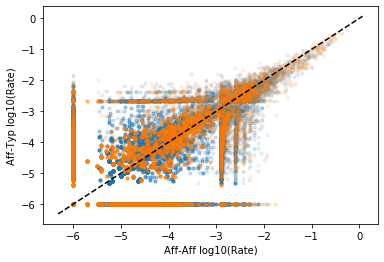

In [394]:
plt.scatter(np.log10(np.clip(mat_ihart_status[indices, 0]/num_aff_aff_pairs, 10**-6, None)), np.log10(np.clip(mat_ihart_status[indices, 1]/num_aff_typ_pairs, 10**-6, None)), alpha=0.1, marker='.')
plt.scatter(np.log10(np.clip(pat_ihart_status[indices, 0]/num_aff_aff_pairs, 10**-6, None)), np.log10(np.clip(pat_ihart_status[indices, 1]/num_aff_typ_pairs, 10**-6, None)), alpha=0.1, marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')

plt.xlabel('Aff-Aff log10(Rate)')
plt.ylabel('Aff-Typ log10(Rate)')
plt.show()

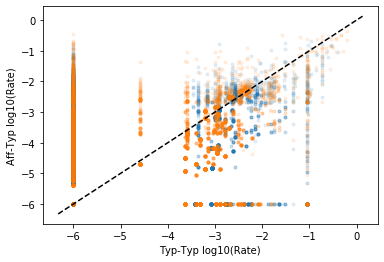

In [395]:
plt.scatter(np.log10(np.clip(mat_ihart_status[indices, 2]/num_typ_typ_pairs, 10**-6, None)), np.log10(np.clip(mat_ihart_status[indices, 1]/num_aff_typ_pairs, 10**-6, None)), alpha=0.1, marker='.')
plt.scatter(np.log10(np.clip(pat_ihart_status[indices, 2]/num_typ_typ_pairs, 10**-6, None)), np.log10(np.clip(pat_ihart_status[indices, 1]/num_aff_typ_pairs, 10**-6, None)), alpha=0.1, marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')

plt.xlabel('Typ-Typ log10(Rate)')
plt.ylabel('Aff-Typ log10(Rate)')

plt.show()

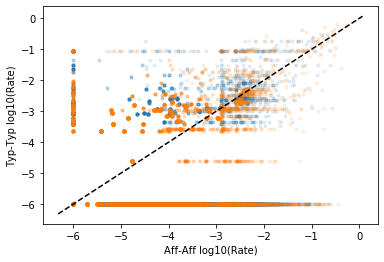

In [396]:
plt.scatter(np.log10(np.clip(mat_ihart_status[indices, 0]/num_aff_aff_pairs, 10**-6, None)), np.log10(np.clip(mat_ihart_status[indices, 2]/num_typ_typ_pairs, 10**-6, None)), alpha=0.1, marker='.')
plt.scatter(np.log10(np.clip(pat_ihart_status[indices, 0]/num_aff_aff_pairs, 10**-6, None)), np.log10(np.clip(pat_ihart_status[indices, 2]/num_typ_typ_pairs, 10**-6, None)), alpha=0.1, marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.xlabel('Aff-Aff log10(Rate)')
plt.ylabel('Typ-Typ log10(Rate)')

plt.show()